# Vision Transformers (ViT)

- Vision Transformers (ViT) represent a groundbreaking approach to computer vision tasks, applying transformer architectures traditionally used in NLP to image processing. 

- Introduced by Dosovitskiy et al. in 2020 in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", ViT has demonstrated remarkable performance on image classification tasks.

<center>
    <img src="../static/VIT.png" alt="Vision Transformers" style="width:50%;">
</center>

Vision Transformers work by:
1. Splitting an image into fixed-size patches (typically 16x16 pixels)
2. Linearly embedding these patches
3. Adding positional embeddings
4. Processing the resulting sequence with a standard Transformer encoder

Key advantages of Vision Transformers include:
- Global receptive field from the start, unlike CNNs which build it up gradually
- Strong performance on large datasets
- Efficient parallel processing of image patches
- Ability to capture long-range dependencies in images

## Architecture of Vision Transformers

The Vision Transformer architecture consists of several key components:

1. **Patch Embedding**: 
   - Divides the input image into non-overlapping patches
   - Flattens each patch and projects it to a lower-dimensional space
   - Adds a learnable classification token at the start of the sequence

2. **Position Embedding**:
   - Adds learnable position embeddings to provide spatial information
   - Helps the model understand the relative positions of patches

3. **Transformer Encoder**:
   - Multiple layers of multi-head self-attention
   - Feed-forward networks
   - Layer normalization and residual connections

4. **Classification Head**:
   - Uses the transformed classification token for final prediction
   - Typically consists of a simple MLP

## Setting Up the Environment

Let's start by importing the necessary libraries:

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2025-01-20 15:37:15.576622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737405435.594860 1759445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737405435.600616 1759445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 15:37:15.619126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

## Data Preprocessing and Loading

Let's set up the data pipeline using the CIFAR-10 dataset:

In [11]:
# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Strategy 1 - Using Convolutional Embedding

In [13]:
class PatchEmbed(layers.Layer):
    """
    A custom Keras layer that embeds images into a lower-dimensional space using convolutional patches.

    This layer simulates the patch extraction and embedding process similar to what is seen in Vision Transformers,
    where an image is split into patches and each patch is then embedded into a vector of specified dimension.

    Attributes:
        img_size (int): The size of the input images (both height and width), assumed to be square.
        patch_size (int): The size of each patch (both height and width), patches are square.
        embed_dim (int): The dimensionality of the embedding space.
        num_patches (int): The total number of patches that will be extracted from the input image.
        proj (tf.keras.layers.Conv2D): The convolutional layer used to extract and embed patches.
        flatten (tf.keras.layers.Reshape): Layer to flatten the output of convolutional embeddings.

    Methods:
        call: Processes the input tensor through convolutional layers to extract and embed patches.
    """

    def __init__(self, img_size=72, patch_size=6, embed_dim=108):
        """
        Initializes the PatchEmbed layer with given image size, patch size, and embedding dimension.

        Args:
            img_size (int): The height and width of the square input images. Default is 32.
            patch_size (int): The height and width of the square patches to be extracted. Default is 4.
            embed_dim (int): The number of filters (and thus the number of dimensions of the embedding). Default is 64.
        """
        super(PatchEmbed, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='VALID'
        )
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        """
        The forward pass for the PatchEmbed layer.

        Args:
            x (tf.Tensor): The input tensor, a batch of images of shape (batch_size, img_size, img_size, channels).

        Returns:
            tf.Tensor: The output tensor of embedded patches of shape (batch_size, num_patches, embed_dim).
        """
        x = self.proj(x)  # Apply convolutional layer to extract and embed patches
        x = self.flatten(x)  # Flatten the 3D output to 2D
        return x


In [14]:
patchEmbed = PatchEmbed()

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


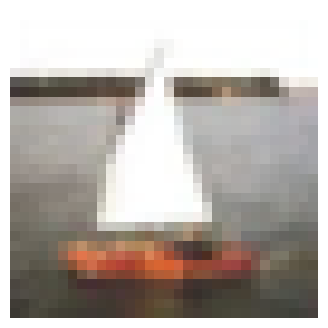

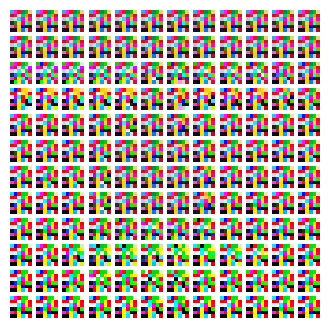

In [15]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.keras.ops.image.resize(
    tf.keras.ops.convert_to_tensor([image]), size=(image_size, image_size)
)
resized_image = tf.cast(resized_image, tf.float64)
patches = PatchEmbed()(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(tf.keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

### SimpleViT Architecture Explanation

The SimpleViT class implements a simplified version of the Vision Transformer architecture with the following key components:

**Initialization Components**
- PatchEmbed layer converts the input image into patches and embeds them
- Position embeddings matrix of shape (1, 64, 64) to encode spatial information[1]
- Multi-head attention layer with 4 heads and key dimension of 16
- Layer normalization for stabilizing the network
- MLP block with two dense layers (128 -> 64 dimensions)
- Classification head for final prediction

**Forward Pass Flow**

1. **Data Augmentation**
- Input Image is augmented

2. **Patch Embedding**
- Input image is divided into patches and embedded using PatchEmbed layer
- Output shape: (batch_size, num_patches, embed_dim)[1]

3. **Position Information**
- Adds learnable position embeddings to provide spatial context
- Position embeddings are added directly to patch embeddings[1]

4. **Transformer Processing**
- Self-attention mechanism processes patch relationships
- Layer normalization and residual connection combine attention output
- MLP further processes the features with residual connection

5. **Classification**
- Global average pooling across patches (reduce_mean)
- Final dense layer produces class logits

This implementation simplifies the original ViT architecture by:
- Using a single transformer block instead of multiple layers
- Omitting the class token
- Simplifying the MLP structure
- Using mean pooling instead of the class token for final classification

In [16]:
class SimpleViT(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(SimpleViT, self).__init__()
        self.augmentation = data_augmentation
        self.patch_embed = PatchEmbed()
        
        # Fix the add_weight call by using keyword arguments properly
        self.pos_embed = self.add_weight(
            shape=(1, 144, 108),  # (1, num_patches, embed_dim)
            initializer="zeros",
            trainable=True,
            name="pos_embed"
        )
        
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=16)
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(128, activation="gelu"),
            layers.Dense(108)
        ])
        
        self.head = layers.Dense(num_classes)

    def call(self, x):
        # Create patches
        x = self.augmentation(x)
        x = self.patch_embed(x)
        
        # Add position embeddings directly
        x = x + self.pos_embed
        
        # Transformer block
        attention_output = self.attention(x, x)
        x = self.layernorm(x + attention_output)
        x = x + self.mlp(x)
        
        # Classification head
        x = tf.reduce_mean(x, axis=1)
        return self.head(x)

Now we'll implement the complete Vision Transformer model:

In [17]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 117s 648ms/step - accuracy: 0.2550 - loss: 2.0357 - top-5-accuracy: 0.7715 - val_accuracy: 0.3790 - val_loss: 1.7109 - val_top-5-accuracy: 0.8768
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 118s 672ms/step - accuracy: 0.3851 - loss: 1.6905 - top-5-accuracy: 0.8753 - val_accuracy: 0.4346 - val_loss: 1.5434 - val_top-5-accuracy: 0.9024
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 117s 667ms/step - accuracy: 0.4439 - loss: 1.5386 - top-5-accuracy: 0.9067 - val_accuracy: 0.4688 - val_loss: 1.4617 - val_top-5-accuracy: 0.9174
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 647ms/step - accuracy: 0.4746 - loss: 1.4542 - top-5-accuracy: 0.9208 - val_accuracy: 0.4898 - val_loss: 1.4041 - val_top-5-accuracy: 0.9280
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 657ms/step - accuracy: 0.4952 - loss: 1.3999 - top-5-accuracy: 0.9291 - val_accuracy: 0.4988 - val_loss: 1.3825 - val_top-5-accuracy: 0.9300
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 121s 686ms/step - accuracy: 0.

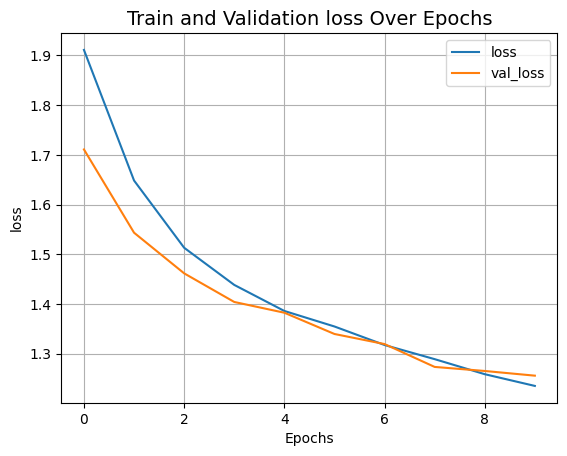

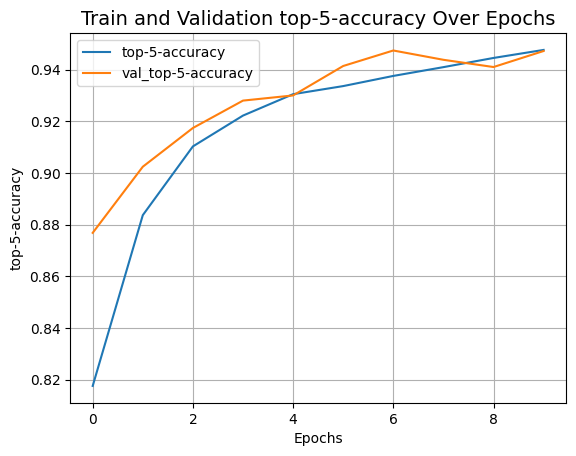

In [18]:
# Create and compile model
model = SimpleViT()
history = run_experiment(model)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

# Strategy 2 - Using Embedding Layer

First, we'll implement the patch creation and embedding layer:

In [19]:
class Patches(layers.Layer):
    """
    A custom Keras layer that extracts patches from input images.

    This layer divides the input images into smaller patches based on the specified patch size,
    flattening these patches into a 2D array where each row represents a patch and maintaining the
    batch size.

    Attributes:
        patch_size (int): The size of each patch (both height and width). Patches are assumed to be square.

    Methods:
        call: Takes an input tensor of images and returns their patches.
        get_config: Returns the configuration of the layer, including the patch size.
    """

    def __init__(self, patch_size):
        """
        Initializes the Patches layer with the specified patch size.

        Args:
            patch_size (int): The size of the patches to extract.
        """
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        """
        This method is called on the forward pass of the model.

        Args:
            images (tf.Tensor): A 4D input tensor with shape (batch_size, height, width, channels).

        Returns:
            tf.Tensor: A 3D tensor with shape (batch_size, num_patches, patch_dim), where
                       num_patches is num_patches_h * num_patches_w and
                       patch_dim is patch_size * patch_size * channels.
        """
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        # Extract patches using TensorFlow's built-in method, 
        # This op collects patches from the input image, as if applying a convolution
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        # Reshape extracted patches to a 2D tensor where each row is a patch
        patches = tf.reshape(
            patches,
            (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels)
        )
        return patches

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.

        Returns:
            dict: A Python dictionary containing the layer configuration.
        """
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


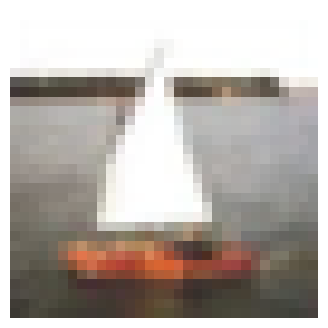

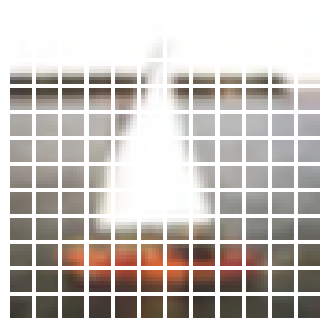

In [20]:
plt.figure(figsize=(4, 4))
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.keras.ops.image.resize(
    tf.keras.ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(tf.keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [21]:
class PatchEncoder(layers.Layer):
    """
    A custom Keras layer that encodes image patches using position embeddings and a linear projection.

    This layer is designed to add positional information to the patches extracted from an image,
    which is a common technique in vision transformer architectures to maintain spatial context.

    Attributes:
        num_patches (int): The number of patches into which an input image is divided.
        projection_dim (int): The dimensionality of the space to which the patches will be projected.
        projection (tf.keras.layers.Dense): The dense layer used for linearly projecting the patches.
        position_embedding (tf.keras.layers.Embedding): The embedding layer used to encode positional information.

    Methods:
        call: Processes the input patches by projecting them and adding positional encodings.
        get_config: Returns the configuration of the layer for serialization.
    """

    def __init__(self, num_patches, projection_dim):
        """
        Initializes the PatchEncoder with the number of patches and the projection dimension.

        Args:
            num_patches (int): Total number of patches extracted from an image.
            projection_dim (int): The size of the dimension to which patches are projected.
        """
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        """
        Forward pass for the PatchEncoder layer.

        Args:
            patch (tf.Tensor): The input tensor containing the patches.
                               Shape should be (batch_size, num_patches, patch_dimension).

        Returns:
            tf.Tensor: The output tensor with encoded patches.
                       Shape is (batch_size, num_patches, projection_dim).
        """
        # Create a tensor of patch positions
        positions = tf.keras.ops.expand_dims(
            tf.keras.ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )

        # Project the patches to the specified dimension
        projected_patches = self.projection(patch)

        # Add position embeddings to the projected patches
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        """
        Overrides the base method to include specific configuration of this layer.

        Returns:
            dict: A configuration dictionary containing the layer's parameters.
        """
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config


In [22]:

def mlp(x, hidden_units, dropout_rate):
    """
    Constructs a multilayer perceptron (MLP) with specified hidden layers and dropout for regularization.

    This function is typically used to create the dense layers followed by dropout in a neural network,
    commonly found in the feedforward part of transformers or other architectures where nonlinear processing
    and regularization are necessary.

    Args:
        x (tf.Tensor): Input tensor to the MLP.
        hidden_units (list of int): Defines the number of units in each dense layer of the MLP.
        dropout_rate (float): The dropout rate to apply after each dense layer.

    Returns:
        tf.Tensor: The output tensor after passing through the MLP layers.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)  # Apply a Dense layer with GELU activation
        x = layers.Dropout(dropout_rate)(x)  # Apply Dropout for regularization
    return x

In [23]:
def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, transformer_layers, num_heads, transformer_units, mlp_head_units, num_classes, data_augmentation):
    """
    Constructs a Vision Transformer model for image classification.

    This function builds a complete ViT architecture starting from input images and culminating
    in classification logits. It includes data augmentation, patch extraction and encoding, multiple
    transformer blocks, and a final MLP head for classification.

    Args:
        input_shape (tuple): The shape of the input images.
        patch_size (int): The size of each image patch.
        num_patches (int): The number of patches to be extracted from each image.
        projection_dim (int): The size of the projection dimension for encoding patches.
        transformer_layers (int): The number of transformer layers to be used.
        num_heads (int): The number of attention heads in each transformer layer.
        transformer_units (list of int): A list of two integers defining the size of the transformer MLP.
        mlp_head_units (list of int): A list of integers defining the size of the dense layers in the final MLP head.
        num_classes (int): The number of output classes for classification.
        data_augmentation (tf.keras.Model): A Keras model for performing data augmentation.

    Returns:
        tf.keras.Model: A Keras model representing the Vision Transformer architecture.
    """

    inputs = tf.keras.Input(shape=input_shape)
    # Augment data using the provided data augmentation model.
    augmented = data_augmentation(inputs)
    # Create patches from the augmented images.
    patches = Patches(patch_size)(augmented)
    # Encode patches to create a sequence of embeddings.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Apply multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Apply the first layer normalization.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Apply multi-head attention with specified number of heads and key dimension.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Add skip connection after attention.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Apply the second layer normalization.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply an MLP block defined externally as function 'mlp'.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Add another skip connection after the MLP.
        encoded_patches = layers.Add()([x3, x2])

    # Normalize and flatten the output to prepare for the classification head.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    # Apply dropout for regularization.
    representation = layers.Dropout(0.5)(representation)
    # Add the final MLP head.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Produce classification logits as output.
    logits = layers.Dense(num_classes)(features)
    # Create and return the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# Patch Embedding Layer Explanation

The PatchEmbed class is a crucial component of the Vision Transformer that transforms input images into a sequence of embedded patches.

**Input Processing**
- Takes an image of size `img_size x img_size` (default 32x32)
- Divides it into non-overlapping patches of size `patch_size x patch_size` (default 4x4)
- The total number of patches is calculated as `(img_size // patch_size)²`[1]

**Layer Components**

1. **Convolutional Projection**
- Uses a Conv2D layer with:
  - `embed_dim` output filters (default 64)
  - Kernel size equal to patch_size (4x4)
  - Stride equal to patch_size for non-overlapping patches
  - 'VALID' padding to avoid padding artifacts[1]

2. **Flattening Operation**
- Reshapes the convolution output into a sequence of patch embeddings
- Transforms the 4D tensor into a 2D sequence of shape `(num_patches, embed_dim)`[1]

**Workflow**
1. Input image (batch_size, height, width, channels)
2. Conv2D projects patches to embedding dimension
3. Reshape flattens spatial dimensions into sequence
4. Output shape: (batch_size, num_patches, embed_dim)[1]

This layer effectively converts a 2D image into a sequence of embedded patches that can be processed by the transformer architecture.

## Model Configuration and Training

Here's how we can configure and train the Vision Transformer:

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1378s 8s/step - accuracy: 0.2546 - loss: 2.8027 - top-5-accuracy: 0.7309 - val_accuracy: 0.4530 - val_loss: 1.5335 - val_top-5-accuracy: 0.9216
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1271s 7s/step - accuracy: 0.4243 - loss: 1.5915 - top-5-accuracy: 0.8961 - val_accuracy: 0.5320 - val_loss: 1.2953 - val_top-5-accuracy: 0.9452
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1249s 7s/step - accuracy: 0.4910 - loss: 1.4208 - top-5-accuracy: 0.9234 - val_accuracy: 0.5892 - val_loss: 1.1789 - val_top-5-accuracy: 0.9520
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1267s 7s/step - accuracy: 0.5241 - loss: 1.3284 - top-5-accuracy: 0.9365 - val_accuracy: 0.6026 - val_loss: 1.1230 - val_top-5-accuracy: 0.9572
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1321s 8s/step - accuracy: 0.5592 - loss: 1.2414 - top-5-accuracy: 0.9447 - val_accuracy: 0.6472 - val_loss: 0.9937 - val_top-5-accuracy: 0.9680
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1310s 7s/step - accuracy: 0.5811 - loss:

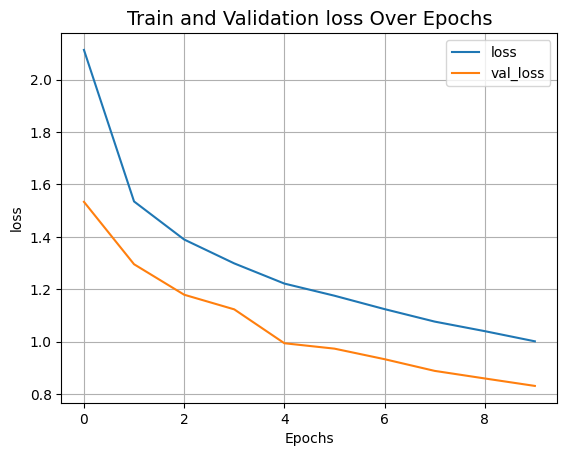

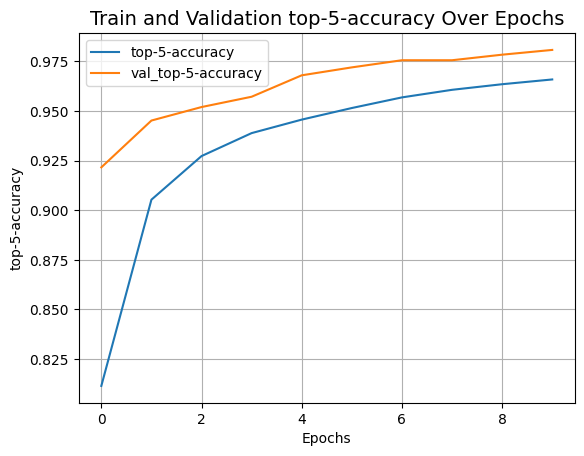

In [25]:

def run_experiment(model):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier(input_shape = (32, 32, 3), patch_size = patch_size, num_patches = num_patches, projection_dim = projection_dim, 
                                       transformer_layers = transformer_layers, num_heads = num_heads, transformer_units = transformer_units,
                                         mlp_head_units = mlp_head_units, num_classes = 100, data_augmentation = data_augmentation)
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

## Conclusion

Vision Transformers represent a powerful alternative to traditional convolutional neural networks for image classification tasks. Their ability to process images as sequences of patches and capture global dependencies makes them particularly effective for many computer vision applications. While they typically require more data and computational resources than CNNs for training from scratch, they can achieve state-of-the-art performance when properly trained.

Key takeaways from this implementation:
- Vision Transformers can effectively process images by treating them as sequences of patches
- The architecture maintains the core components of the original Transformer while adapting them for image data
- The model can be effectively trained on standard image classification datasets
- Attention mechanisms provide interpretability through visualization of learned patterns